In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [52]:
# Import Dataset
df=pd.read_csv('./apple_data.csv')

               Open          High           Low         Close     Adj Close  \
count  10954.000000  10954.000000  10954.000000  10954.000000  10954.000000   
mean      21.530877     21.761904     21.308220     21.544072     20.747506   
std       44.458386     44.931856     44.013578     44.492483     44.038943   
min        0.049665      0.049665      0.049107      0.049107      0.037900   
25%        0.296875      0.303571      0.290179      0.296875      0.241624   
50%        0.522321      0.533482      0.513393      0.524554      0.427333   
75%       19.767500     19.888572     19.457768     19.682679     17.048054   
max      198.020004    199.619995    197.000000    198.110001    197.589523   

             Volume  
count  1.095400e+04  
mean   3.190792e+08  
std    3.357446e+08  
min    0.000000e+00  
25%    1.139936e+08  
50%    2.067128e+08  
75%    3.993444e+08  
max    7.421641e+09  
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0


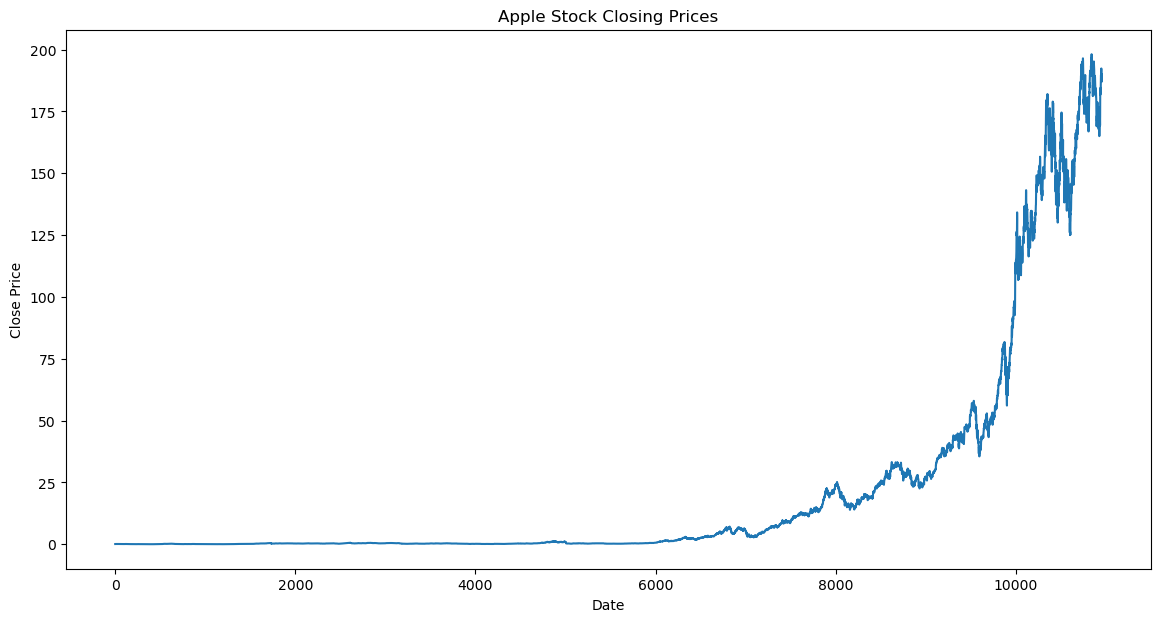

In [53]:
# Display basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Plotting the closing price
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Apple Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [54]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop(["Adj Close"], axis=1)
# df["return"] = np.log(df["Close"]).diff(1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600


In [55]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_test_split_(df, train_end, window_size):
    series = df.copy()
    train_series, test_series = series[:train_end], series[(train_end - window_size):]
    return train_series, test_series

def min_max_scale(train, test):
    scaler=StandardScaler()
    train_s = scaler.fit_transform(train)
    test_s = scaler.transform(test)
    return train_s, test_s


def getData(data,target_col_idx, n_past=30):
    dataX = []
    dataY = []
    for i in range(n_past, len(data)):
        dataX.append(data[(i - n_past):i, :])
        dataY.append(data[i, target_col_idx])
    return np.array(dataX),np.array(dataY)


In [56]:
# split data
train, test = train_test_split_(df, -2000, 30)
train, test = min_max_scale(train, test)
X_train, y_train = getData(train, 3)
X_test, y_test = getData(test,3)

In [57]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y
    
    
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
#         # 初始化隐藏状态和细胞状态
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 通过LSTM层
        out, _ = self.lstm(x)

        # 通过全连接层
        out = self.fc(out[:, -1, :])
        return out

In [64]:
# 设置随机数种子
torch.manual_seed(11)

dataset = SequenceDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 创建模型
model = LSTMModel(input_size=df.shape[1])

# 训练模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 3
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        # 前向传播
        y_pred = model(X_batch)
#         print(y_pred)
#         print(y_batch.unsqueeze(1))
        loss = criterion(y_pred, y_batch.unsqueeze(1))

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.10f}')


Epoch [1/3], Loss: 0.0016355914
Epoch [2/3], Loss: 0.0008911440
Epoch [3/3], Loss: 0.0003479312


In [65]:
X_train.shape

(8924, 30, 5)

In [66]:


# 预测
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_train).float())
    print(y_pred.shape)
#     future_outputs.append(future_output)
#     future_input = torch.cat((future_input[:, 1:, :], future_output.unsqueeze(1)), dim=1)

# future_outputs = torch.stack(future_outputs, dim=1)
# future_outputs = scaler.inverse_transform(future_outputs.squeeze().T)

torch.Size([8924, 1])


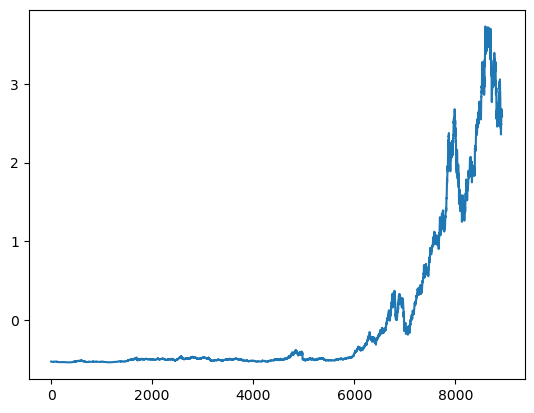

In [67]:
plt.plot(y_train)

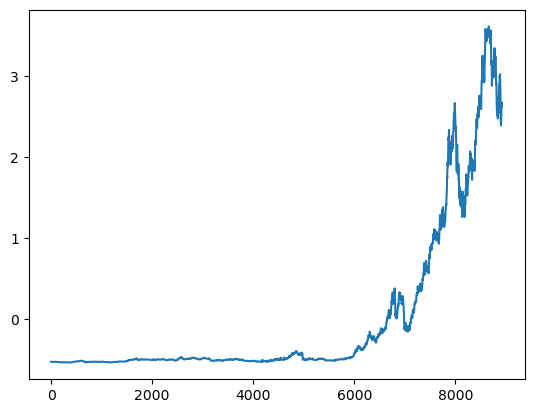

In [68]:
plt.plot(y_pred)